In [ ]:
#|hide
#|default_exp shell

# shell

> A shell for running notebook code without a notebook server

In [ ]:
#|export
from __future__ import annotations

from fastcore.utils import *
from fastcore.script import call_parse

import multiprocessing,types,traceback
try:
    if sys.platform == 'darwin': multiprocessing.set_start_method("fork")
except RuntimeError: pass # if re-running cell

from IPython.core.interactiveshell import InteractiveShell, ExecutionInfo, ExecutionResult
from IPython.core.displayhook import DisplayHook
from IPython.utils.capture import capture_output
from IPython.core.completer import IPCompleter,provisionalcompleter
from IPython.core.hooks import CommandChainDispatcher
from IPython.core.completerlib import module_completer
from IPython.utils.strdispatch import StrDispatch
from IPython.display import display as disp, HTML

from base64 import b64encode
from html import escape
try: from matplotlib_inline.backend_inline import set_matplotlib_formats
except ImportError: set_matplotlib_formats = None

from execnb.nbio import *
from execnb.nbio import _dict2obj

In [ ]:
from fastcore.test import *
from base64 import b64decode
from io import BytesIO
from PIL import Image

## CaptureShell -

In [ ]:
#|export
class _CustDisplayHook(DisplayHook):
    def write_output_prompt(self): pass
    def write_format_data(self, data, md_dict): pass
    def log_output(self, format_dict): pass

@patch
def __repr__(self: ExecutionInfo): return f'cell: {self.raw_cell}; id: {self.cell_id}'

@patch
def __repr__(self: ExecutionResult): return f'result: {self.result}; err: {self.error_in_exec}; info: <{self.info}>'

In [ ]:
#|export
class CaptureShell(InteractiveShell):
    displayhook_class = _CustDisplayHook

    def __init__(self, path:str|Path=None, mpl_format='retina'):
        super().__init__()
        self.result,self.exc = None,None
        if path: self.set_path(path)
        self.display_formatter.active = True
        if not IN_NOTEBOOK: InteractiveShell._instance = self
        if set_matplotlib_formats:
            self.run_cell("from matplotlib_inline.backend_inline import set_matplotlib_formats")
            self.run_cell(f"set_matplotlib_formats('{mpl_format}')")
            self.run_cell('%matplotlib inline')

    def run_cell(self, raw_cell, store_history=False, silent=False, shell_futures=True, cell_id=None,
                 stdout=True, stderr=True, display=True):
        # TODO what if there's a comment?
        semic = raw_cell.rstrip().endswith(';')
        with capture_output(display=display, stdout=stdout, stderr=stderr) as c:
            result = super().run_cell(raw_cell, store_history, silent, shell_futures=shell_futures, cell_id=cell_id)
        return AttrDict(result=result, stdout='' if semic else c.stdout, stderr=c.stderr,
                        display_objects=c.outputs, exception=result.error_in_exec, quiet=semic)
    
    def set_path(self, path):
        "Add `path` to python path, or `path.parent` if it's a file"
        path = Path(path)
        if path.is_file(): path = path.parent
        self.run_cell(f"import sys; sys.path.insert(0, '{path.as_posix()}')")

In [ ]:
s = CaptureShell(mpl_format='retina')

In [ ]:
s.run_cell('a=1');

In [ ]:
o = s.run_cell('print(a)')
o

```json
{ 'display_objects': [],
  'exception': None,
  'quiet': False,
  'result': result: None; err: None; info: <cell: print(a); id: None>,
  'stderr': '',
  'stdout': '1\n'}
```

In [ ]:
o = s.run_cell('from warnings import warn; warn("1")')
o

```json
{ 'display_objects': [],
  'exception': None,
  'quiet': False,
  'result': result: None; err: None; info: <cell: from warnings import warn; warn("1"); id: None>,
  'stderr': '<ipython-input-1-a51443ae013a>:1: UserWarning: 1\n'
            '  from warnings import warn; warn("1")\n',
  'stdout': ''}
```

In [ ]:
o = s.run_cell('1')
o

```json
{ 'display_objects': [],
  'exception': None,
  'quiet': False,
  'result': result: 1; err: None; info: <cell: 1; id: None>,
  'stderr': '',
  'stdout': ''}
```

In [ ]:
o = s.run_cell('from IPython.display import Markdown,display; print(0); display(Markdown("*2*")); Markdown("*1*")')
o

```json
{ 'display_objects': [<IPython.utils.capture.RichOutput object>],
  'exception': None,
  'quiet': False,
  'result': result: <IPython.core.display.Markdown object>; err: None; info: <cell: from IPython.display import Markdown,display; print(0); display(Markdown("*2*")); Markdown("*1*"); id: None>,
  'stderr': '',
  'stdout': '0\n'}
```

In [ ]:
o.result.result

*1*

In [ ]:
o.display_objects[0]

*2*

In [ ]:
o = s.run_cell('1;')
o

```json
{ 'display_objects': [],
  'exception': None,
  'quiet': True,
  'result': result: 1; err: None; info: <cell: 1;; id: None>,
  'stderr': '',
  'stdout': ''}
```

In [ ]:
o = s.run_cell('import matplotlib.pyplot as plt; plt.plot([1,2,3])')
o

```json
{ 'display_objects': [<IPython.utils.capture.RichOutput object>],
  'exception': None,
  'quiet': False,
  'result': result: [<matplotlib.lines.Line2D object>]; err: None; info: <cell: import matplotlib.pyplot as plt; plt.plot([1,2,3]); id: None>,
  'stderr': '',
  'stdout': ''}
```

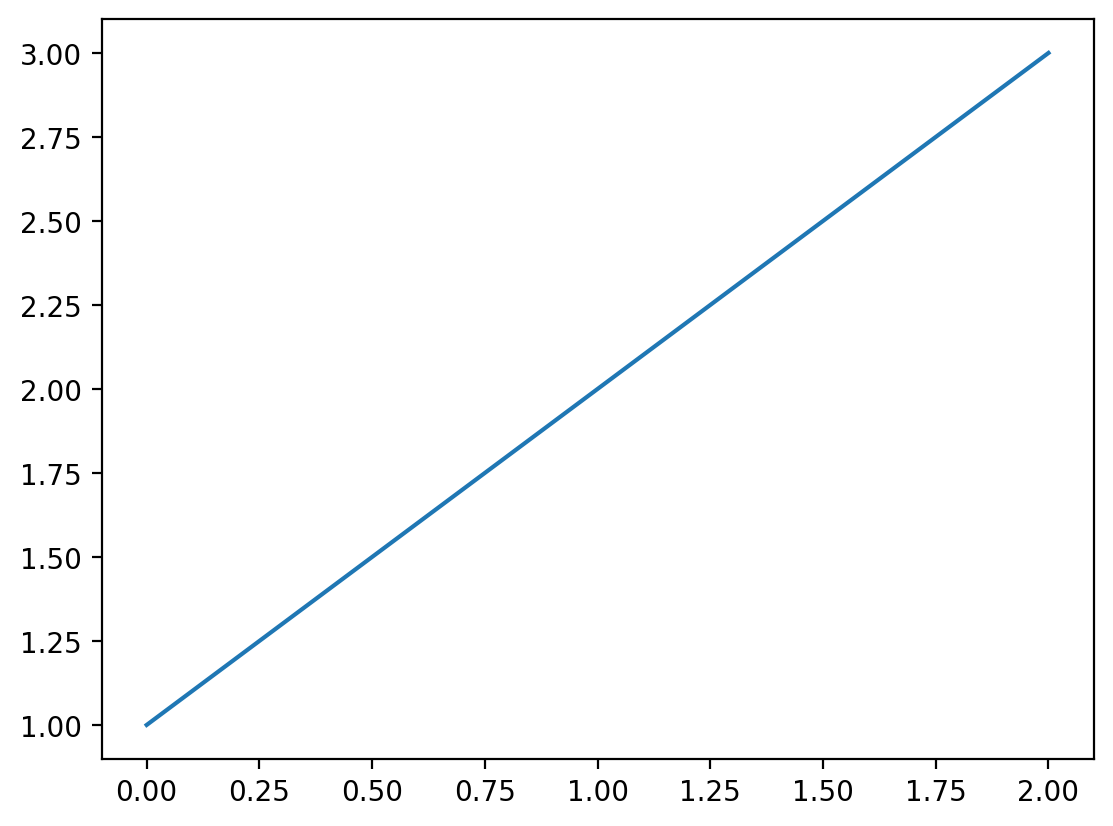

In [ ]:
o.display_objects[0]

In [ ]:
o = s.run_cell('''
import pandas as pd
pd.DataFrame({'A': [1, 2], 'B': [3, 4]})''')
o

```json
{ 'display_objects': [],
  'exception': None,
  'quiet': False,
  'result': result:    A  B
0  1  3
1  2  4; err: None; info: <cell: 
import pandas as pd
pd.DataFrame({'A': [1, 2], 'B': [3, 4]}); id: None>,
  'stderr': '',
  'stdout': ''}
```

In [ ]:
o.result.result

,A,B
0,1,3
1,2,4


In [ ]:
o = s.run_cell('1/0')
o

```json
{ 'display_objects': [],
  'exception': ZeroDivisionError('division by zero'),
  'quiet': False,
  'result': result: None; err: division by zero; info: <cell: 1/0; id: None>,
  'stderr': '',
  'stdout': '\x1b[0;31m---------------------------------------------------------------------------\x1b[0m\n'
            '\x1b[0;31mZeroDivisionError\x1b[0m                         '
            'Traceback (most recent call last)\n'
            'File \x1b[0;32m<ipython-input-1-9e1622b385b6>:1\x1b[0m\n'
            '\x1b[0;32m----> 1\x1b[0m '
            '\x1b[38;5;241;43m1\x1b[39;49m\x1b[38;5;241;43m/\x1b[39;49m\x1b[38;5;241;43m0\x1b[39;49m\n'
            '\n'
            '\x1b[0;31mZeroDivisionError\x1b[0m: division by zero\n'}
```

### Cells

In [ ]:
#| export
def format_exc(e):
    "Format exception `e` as a string"
    return ''.join(traceback.format_exception(type(e), e, e.__traceback__))

In [ ]:
#|export
def _out_stream(text, name): return dict(name=name, output_type='stream', text=text.splitlines(True))
def _out_exc(e):
    ename = type(e).__name__
    tb = traceback.extract_tb(e.__traceback__)#.format()
    return dict(ename=str(ename), evalue=str(e), output_type='error', traceback=format_exc(e))

def _format_mimedata(k, v):
    "Format mime-type keyed data consistently with Jupyter"
    if k.startswith('text/'): return v.splitlines(True)
    if k.startswith('image/') and isinstance(v, bytes):
        v = b64encode(v).decode()
        return v+'\n' if not v.endswith('\n') else v
    return v

def _mk_out(data, meta, output_type='display_data'):
    fd = {k:_format_mimedata(k,v) for k,v in data.items()}
    return dict(data=fd, metadata=meta, output_type=output_type)

def _out_nb(o, fmt):
    res = []
    if o.stdout: res.append(_out_stream(o.stdout, 'stdout'))
    if o.stderr: res.append(_out_stream(o.stderr, 'stderr'))
    if o.exception: res.append(_out_exc(o.exception))
    r = o.result.result
    for x in o.display_objects: res.append(_mk_out(x.data, x.metadata))
    if r is not None and not o.quiet:
        res.append(_mk_out(*fmt.format(r), 'execute_result'))
    return res

In [ ]:
#|export
@patch
def run(self:CaptureShell,
        code:str, # Python/IPython code to run
        stdout=True, # Capture stdout and save as output?
        stderr=True): # Capture stderr and save as output?
    "Run `code`, returning a list of all outputs in Jupyter notebook format"
    res = self.run_cell(code, stdout=stdout, stderr=stderr)
    self.result = res.result.result
    self.exc = res.exception
    return _out_nb(res, self.display_formatter)

In [ ]:
s = CaptureShell()

In [ ]:
s.run("print(1)")

[{'name': 'stdout', 'output_type': 'stream', 'text': ['1\n']}]

Code can include magics and `!` shell commands:

In [ ]:
o = s.run("%time 1+1")
o

[{'name': 'stdout',
  'output_type': 'stream',
  'text': ['CPU times: user 1 us, sys: 1 us, total: 2 us\n',
   'Wall time: 1.91 us\n']},
 {'data': {'text/plain': ['2']},
  'metadata': {},
  'output_type': 'execute_result'}]

In [ ]:
#| export
def render_outputs(outputs):
    has_error = any(o['output_type']=='error' for o in outputs)
    def render_output(out):
        otype = out['output_type']
        if otype == 'stream' and not has_error:
            txt = ''.join(out['text'])
            return f"<pre>{txt}</pre>" if out['name']=='stdout' else f"<pre class='stderr'>{txt}</pre>"
        elif otype in ('display_data','execute_result'):
            data = out['data']
            _g = lambda t: ''.join(data[t]) if t in data else None
            if d := _g('text/html'): return d
            if d := _g('application/javascript'): return f'<script>{d}</script>'
            if d := _g('text/markdown'): return markdown.markdown(d)
            if d := _g('image/svg+xml'): return d
            if d := _g('image/jpeg'): return f'<img src="data:image/jpeg;base64,{d}"/>'
            if d := _g('image/png'): return f'<img src="data:image/png;base64,{d}"/>'
            if d := _g('text/latex'): return f'<div class="math">${d}$</div>'
            if d := _g('text/plain'): return f"<pre>{escape(d)}</pre>"
        elif otype == 'error':
            tb = ''.join(out['traceback'])
            return f"<pre class='error'>{out['ename']}: {out['evalue']}\n{tb}</pre>"
        return ''
    
    return '\n'.join(filter(None, map(render_output, outputs)))

In [ ]:
HTML(render_outputs(o))

The result of the last successful execution is stored in `result`:

In [ ]:
s.result

2

A trailing `;` stops the result from being captured:

In [ ]:
s.run("1+2;")

[]

Images and matplotlib figures are captured:


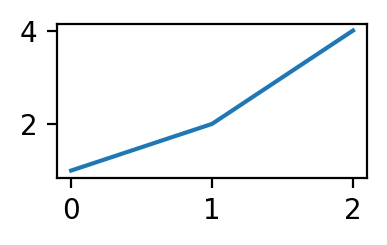

In [ ]:
res = s.run('''import matplotlib.pyplot as plt
plt.figure(figsize=(2,1))
plt.plot([1,2,4]);''')

HTML(render_outputs(res))

If an exception is raised then the exception type, object, and stacktrace are stored in `exc`:

In [ ]:
o = s.run('raise Exception("Oops")')
o

[{'name': 'stdout',
  'output_type': 'stream',
  'text': ['\x1b---------------------------------------------------------------------------\x1b\n',
   '\x1bException\x1b                                 Traceback (most recent call last)\n',
   'File \x1b<ipython-input-1-01648acb07bd>:1\x1b\n',
   '\x1b----> 1\x1b \x1braise\x1b \x1bException\x1b(\x1b"\x1b\x1bOops\x1b\x1b"\x1b)\n',
   '\n',
   '\x1bException\x1b: Oops\n']},
 {'ename': 'Exception',
  'evalue': 'Oops',
  'output_type': 'error',
  'traceback': 'Traceback (most recent call last):\n  File "/Users/nathan/git/.venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code\n    exec(code_obj, self.user_global_ns, self.user_ns)\n  File "<ipython-input-1-01648acb07bd>", line 1, in <module>\n    raise Exception("Oops")\nException: Oops\n'}]

In [ ]:
HTML(render_outputs(o))

In [ ]:
HTML(render_outputs(s.run('1/0')))

In [ ]:
s.exc

ZeroDivisionError('division by zero')

In [ ]:
#|export
@patch
def cell(self:CaptureShell, cell, stdout=True, stderr=True):
    "Run `cell`, skipping if not code, and store outputs back in cell"
    if cell.cell_type!='code': return
    self._cell_idx = cell.idx_ + 1
    outs = self.run(cell.source)
    if outs:
        cell.outputs = _dict2obj(outs)
        for o in outs:
            if 'execution_count' in o: cell['execution_count'] = o['execution_count']

In [ ]:
clean = Path('../tests/clean.ipynb')
nb = read_nb(clean)
c = nb.cells[1]
c

```json
{ 'cell_type': 'code',
  'execution_count': None,
  'id': 'b123d6d0',
  'idx_': 1,
  'metadata': {},
  'outputs': [],
  'source': 'print(1)\n2'}
```

In [ ]:
s.cell(c)
c.outputs

[{'name': 'stdout', 'output_type': 'stream', 'text': ['1\n']},
 {'data': {'text/plain': ['2']},
  'metadata': {},
  'output_type': 'execute_result'}]

In [ ]:
#| export
def find_output(outp, # Output from `run`
                ot='execute_result' # Output_type to find
               ):
    "Find first output of type `ot` in `CaptureShell.run` output"
    return first(o for o in outp if o['output_type']==ot)

In [ ]:
find_output(c.outputs)['data']

```json
{'text/plain': ['2']}
```

In [ ]:
find_output(c.outputs, 'stream')['text']

['1\n']

In [ ]:
#| export
def out_exec(outp):
    "Get data from execution result in `outp`."
    out = find_output(outp)
    if out: return '\n'.join(first(out['data'].values()))

In [ ]:
out_exec(c.outputs)

'2'

In [ ]:
#| export
def out_stream(outp):
    "Get text from stream in `outp`."
    out = find_output(outp, 'stream')
    if out: return ('\n'.join(out['text'])).strip()

In [ ]:
out_stream(c.outputs)

'1'

In [ ]:
#| export
def out_error(outp):
    "Get traceback from error in `outp`."
    out = find_output(outp, 'error')
    if out: return '\n'.join(out['traceback'])

### NBs -

In [ ]:
#|export
def _false(o): return False

@patch
def run_all(self:CaptureShell,
            nb, # A notebook read with `nbclient` or `read_nb`
            exc_stop:bool=False, # Stop on exceptions?
            preproc:Callable=_false, # Called before each cell is executed
            postproc:Callable=_false, # Called after each cell is executed
            inject_code:str|None=None, # Code to inject into a cell
            inject_idx:int=0 # Cell to replace with `inject_code`
           ):
    "Run all cells in `nb`, stopping at first exception if `exc_stop`"
    if inject_code is not None: nb.cells[inject_idx].source = inject_code
    for cell in nb.cells:
        if not preproc(cell):
            self.cell(cell)
            postproc(cell)
        if self.exc and exc_stop: raise self.exc from None

In [ ]:
nb.cells[2].outputs

[]

In [ ]:
s.run_all(nb)
nb.cells[2].outputs

[{'data': {'text/plain': ['<IPython.core.display.Markdown object>'],
   'text/markdown': ["This is *bold*. Here's a [link](https://www.fast.ai)."]},
  'metadata': {},
  'output_type': 'execute_result'}]

With `exc_stop=False` (the default), execution continues after exceptions, and exception details are stored into the appropriate cell's output:

In [ ]:
nb.cells[-1].source

'raise Exception("Oopsie!")'

In [ ]:
nb.cells[-1].outputs

[{'name': 'stdout',
  'output_type': 'stream',
  'text': ['\x1b---------------------------------------------------------------------------\x1b\n',
   '\x1bException\x1b                                 Traceback (most recent call last)\n',
   'File \x1b<ipython-input-1-1c97c1d317ab>:1\x1b\n',
   '\x1b----> 1\x1b \x1braise\x1b \x1bException\x1b(\x1b"\x1b\x1bOopsie!\x1b\x1b"\x1b)\n',
   '\n',
   '\x1bException\x1b: Oopsie!\n']},
 {'ename': 'Exception',
  'evalue': 'Oopsie!',
  'output_type': 'error',
  'traceback': 'Traceback (most recent call last):\n  File "/Users/nathan/git/.venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code\n    exec(code_obj, self.user_global_ns, self.user_ns)\n  File "<ipython-input-1-1c97c1d317ab>", line 1, in <module>\n    raise Exception("Oopsie!")\nException: Oopsie!\n'}]

With `exc_stop=True`, exceptions in a cell are raised and no further processing occurs:

In [ ]:
try: s.run_all(nb, exc_stop=True)
except Exception as e: print(f"got exception: {e}")

got exception: Oopsie!


We can pass a function to `preproc` to have it run on every cell. It can modify the cell as needed. If the function returns `True`, then that cell will not be executed. For instance, to skip the cell which raises an exception:

In [ ]:
nb = read_nb(clean)
s.run_all(nb, preproc=lambda c: 'raise' in c.source)

This cell will contain no output, since it was skipped.

In [ ]:
nb.cells[-1].outputs

[]

In [ ]:
nb.cells[1].outputs

[{'name': 'stdout', 'output_type': 'stream', 'text': ['1\n']},
 {'data': {'text/plain': ['2']},
  'metadata': {},
  'output_type': 'execute_result'}]

You can also pass a function to `postproc` to modify a cell after it is executed.

In [ ]:
#|export
@patch
def execute(self:CaptureShell,
            src:str|Path, # Notebook path to read from
            dest:str|None=None, # Notebook path to write to
            exc_stop:bool=False, # Stop on exceptions?
            preproc:Callable=_false, # Called before each cell is executed
            postproc:Callable=_false, # Called after each cell is executed
            inject_code:str|None=None, # Code to inject into a cell
            inject_path:str|Path|None=None, # Path to file containing code to inject into a cell
            inject_idx:int=0 # Cell to replace with `inject_code`
):
    "Execute notebook from `src` and save with outputs to `dest"
    nb = read_nb(src)
    self._fname = src
    self.set_path(Path(src).parent.resolve())
    if inject_path is not None: inject_code = Path(inject_path).read_text()
    self.run_all(nb, exc_stop=exc_stop, preproc=preproc, postproc=postproc,
                 inject_code=inject_code, inject_idx=inject_idx)
    if dest: write_nb(nb, dest)

This is a shortcut for the combination of `read_nb`, `CaptureShell.run_all`, and `write_nb`.

In [ ]:
s = CaptureShell()
try:
    s.execute(clean, 'tmp.ipynb')
    print(read_nb('tmp.ipynb').cells[1].outputs)
finally: Path('tmp.ipynb').unlink()

[{'name': 'stdout', 'output_type': 'stream', 'text': ['1\n']}, {'data': {'text/plain': ['2']}, 'metadata': {}, 'output_type': 'execute_result'}]


In [ ]:
p = Path.home()/'git'/'fastcore'/'nbs'
n = p/'03a_parallel.ipynb'

In [ ]:
#|export
@patch
def prettytb(self:CaptureShell, 
             fname:str|Path=None): # filename to print alongside the traceback
    "Show a pretty traceback for notebooks, optionally printing `fname`."
    fname = fname if fname else self._fname
    _fence = '='*75
    cell_intro_str = f"While Executing Cell #{self._cell_idx}:" if self._cell_idx else "While Executing:"
    cell_str = f"\n{cell_intro_str}\n{format_exc(self.exc)}"
    fname_str = f' in {fname}' if fname else ''
    return f"{type(self.exc).__name__}{fname_str}:\n{_fence}\n{cell_str}\n"

If an error occurs while running a notebook, you can retrieve a pretty version of the error with the `prettytb` method: 

In [ ]:
s = CaptureShell()
try:
    s.execute('../tests/error.ipynb', exc_stop=True)
except:
    print(s.prettytb())

AssertionError in ../tests/error.ipynb:

While Executing Cell #2:
Traceback (most recent call last):
  File "/var/folders/5f/gb9vtfjd68q8pwth3s3t67rr0000gn/T/ipykernel_80465/1421292703.py", line 3, in <module>
    s.execute('../tests/error.ipynb', exc_stop=True)
  File "/var/folders/5f/gb9vtfjd68q8pwth3s3t67rr0000gn/T/ipykernel_80465/2032771714.py", line 18, in execute
    self.run_all(nb, exc_stop=exc_stop, preproc=preproc, postproc=postproc,
  File "/var/folders/5f/gb9vtfjd68q8pwth3s3t67rr0000gn/T/ipykernel_80465/1738204067.py", line 19, in run_all
    if self.exc and exc_stop: raise self.exc from None
  File "/Users/nathan/git/.venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-1-b968a57a586e>", line 3, in <module>
    foo()
  File "/Users/nathan/git/execnb/tests/err.py", line 2, in foo
    assert 13 == 98
AssertionError




### Tests -

In [ ]:
#|hide
# Trailing `;` stops data from being captured
res = CaptureShell().run('1+1;')
test_eq(res, [])

# Newlines, whitespace, and comments after `;` are ignored
# TODO: fix test
# res = CaptureShell().run('1+1;\n  #commented_func()')
test_eq(res, [])

In [ ]:
#|hide
# Streams are split on and keep newlines
res = CaptureShell().run(r"print('a\nb'); print('c\n\n'); print('d')")
test_eq(res[0]['text'], ['a\n', 'b\n', 'c\n', '\n', '\n', 'd\n'])

In [ ]:
#|hide
# Text mime data are split on and keep newlines
res = CaptureShell().run(r"from IPython.display import Markdown; display(Markdown('a\nb'))")
test_eq(res[0]['data']['text/markdown'], ['a\n', 'b'])

In [ ]:
#|hide
# Binary image mime data are base64-encoded and end in a single `\n`

def _pil2b64(im): return b64encode(im._repr_png_()).decode()+'\n'
im = Image.new('RGB', (3,3), 'red')
imb64 = _pil2b64(im)

res = CaptureShell().run("from PIL import Image; Image.new('RGB', (3,3), 'red')")
test_eq(res[0]['data']['image/png'], imb64)

In [ ]:
#|hide
# `display_data` flushes stdout and stderr - in that order
res = CaptureShell().run("import sys; sys.stderr.write('Error!'); print(1); display(1)")
test_eq(res, [{'name': 'stdout', 'output_type': 'stream', 'text': ['1\n']},
              {'name': 'stderr', 'output_type': 'stream', 'text': ['Error!']},
              {'data': {'text/plain': ['1']}, 'metadata': {}, 'output_type': 'display_data'}])

In [ ]:
#|hide
# Consecutive writes to stdout are grouped
res = CaptureShell().run('print(1); print(2); print(3)')
test_eq(res, [{'name': 'stdout', 'output_type': 'stream', 'text': ['1\n', '2\n', '3\n']}])

In [ ]:
#|hide
# Consecutive writes to stdout are grouped despite an intermediate write to stderr, which is captured after
res = CaptureShell().run("import sys; print(1); print(2); sys.stderr.write('Error!'); print(3)")
test_eq(res, [{'name': 'stdout', 'output_type': 'stream', 'text': ['1\n', '2\n', '3\n']},
              {'name': 'stderr', 'output_type': 'stream', 'text': ['Error!']}])

In [ ]:
#|hide
# `execute_result` is always last
res = CaptureShell().run("import sys; sys.stderr.write('Error!'); print(1); display(1); 1")
test_eq(res, [{'name': 'stdout', 'output_type': 'stream', 'text': ['1\n']},
              {'name': 'stderr', 'output_type': 'stream', 'text': ['Error!']},
              {'data': {'text/plain': ['1']}, 'metadata': {}, 'output_type': 'display_data'},
              {'data': {'text/plain': ['1']}, 'metadata': {}, 'output_type': 'execute_result'}])

## Params -

If you pass `inject_code` to `CaptureShell.execute` or `CaptureShell.run_all`, the source of `nb.cells[inject_idx]` will be replaced with `inject_code`. By default, the first cell is replaced. For instance consider this notebook:

In [ ]:
nb = read_nb('../tests/params.ipynb')
for c in nb.cells: print('- ',c.source)

-  a=1
-  print(a)


We can replace the first cell with `a=2` by passing that as `inject_code`, and the notebook will run with that change:

In [ ]:
nb = read_nb('../tests/params.ipynb')
s.run_all(nb, inject_code="a=2")
list(nb.cells)

[{'cell_type': 'code',
  'execution_count': None,
  'id': 'a63ce885',
  'metadata': {},
  'outputs': [],
  'source': 'a=2',
  'idx_': 0},
 {'cell_type': 'code',
  'execution_count': None,
  'id': 'ea528db5',
  'metadata': {},
  'outputs': [{'name': 'stdout', 'output_type': 'stream', 'text': ['2\n']}],
  'source': 'print(a)',
  'idx_': 1}]

This can be used with `CaptureShell.execute` to parameterise runs of models in notebooks. Place any defaults for configuration code needed in the first cell, and then when running `execute` pass in new parameters as needed in `inject_code`. To replace only some of the defaults, leave an empty cell as the second cell, and inject code using `inject_idx=1` to replace the empty second cell with code that overrides some of the defaults set in the first cell. When using `execute` you can pass `inject_path` instead of `inject_code` to read the injected code from a file.

## cli -

In [ ]:
#|export
@call_parse
def exec_nb(
    src:str, # Notebook path to read from
    dest:str='', # Notebook path to write to
    exc_stop:bool=False, # Stop on exceptions?
    inject_code:str=None, # Code to inject into a cell
    inject_path:str=None, # Path to file containing code to inject into a cell
    inject_idx:int=0 # Cell to replace with `inject_code`
):
    "Execute notebook from `src` and save with outputs to `dest`"
    CaptureShell().execute(src, dest, exc_stop=exc_stop, inject_code=inject_code,
                           inject_path=inject_path, inject_idx=inject_idx)

This is the command-line version of `CaptureShell.execute`. Run `exec_nb -h` from the command line to see how to pass arguments. If you don't pass `dest` then the output notebook won't be saved; this is mainly useful for running tests.

## Completions -

In [ ]:
#| export
class SmartCompleter(IPCompleter):
    def __init__(self, shell, namespace=None, jedi=False):
        if namespace is None: namespace = shell.user_ns
        super().__init__(shell, namespace)
        self.use_jedi = jedi
        sdisp = StrDispatch()
        self.custom_completers = sdisp
        import_disp = CommandChainDispatcher()
        import_disp.add(types.MethodType(module_completer, shell))
        sdisp.add_s('import', import_disp)
        sdisp.add_s('from', import_disp)

    def __call__(self, c):
        if not c: return []
        with provisionalcompleter():
            return [o.text.rpartition('.')[-1]
                    for o in self.completions(c, len(c))
                    if o.type=='<unknown>']

In [ ]:
cc = SmartCompleter(get_ipython())

def test_set(a,b): return test_eq(set(a), set(b))

class _f:
    def __init__(self): self.bar,self.baz,self.room = 0,0,0

foo = _f()

assert set(cc("b")).issuperset(['bool', 'bytes'])
test_set(cc("foo.b"), ['bar', 'baz'])
test_set(cc("x=1; x = foo.b"), ['bar', 'baz'])
test_set(cc("ab"), ['abs'])
test_set(cc("b = ab"), ['abs'])
test_set(cc(""), [])
test_set(cc("foo."), ['bar', 'baz', 'room'])
test_set(cc("nonexistent.b"), [])
test_set(cc("foo.nonexistent.b"), [])
test_set(cc("import ab"), ['abc'])
test_set(cc("from abc import AB"), ['ABC', 'ABCMeta'])

AssertionError: 

In [ ]:
#| export
@patch
def complete(self:CaptureShell, c):
    if not hasattr(self, '_completer'): self._completer = SmartCompleter(self)
    return self._completer(c)

In [ ]:
s = CaptureShell()
s.run('a=1')
s.complete('a.b')

## export -

In [ ]:
#|hide
import nbdev; nbdev.nbdev_export()